# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## 🚀 DeiT-Style Training for CIFAR-100

This notebook implements a **compact, locality-aware Vision Transformer** trained from scratch on CIFAR-100 using a **DeiT (Data-efficient Image Transformer)** style recipe with 100 epochs.

### Key Improvements:
1. **Locality-Aware Architecture**: Convolutional patch embeddings preserve spatial inductive bias
2. **Compact Design**: Optimized for 32×32 images (native CIFAR-100 resolution)
3. **Strong Augmentations**: Random flips, rotations, zoom, translation, contrast adjustments
4. **Label Smoothing**: 0.1 smoothing to prevent overconfidence
5. **Cosine LR Schedule**: With 5-epoch warmup for stable training
6. **Proper Regularization**: AdamW with 0.05 weight decay

**Why this matters**: From-scratch ViTs typically underperform on small datasets without strong augmentation and proper training recipes. This implementation addresses those challenges.

## Setup

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
# DeiT-style hyperparameters for CIFAR-100
learning_rate = 0.001  # Will use cosine decay
weight_decay = 0.05  # Stronger weight decay
batch_size = 128  # Smaller batch for better generalization
num_epochs = 100  # Full training as requested
warmup_epochs = 5
image_size = 32  # Keep native CIFAR-100 resolution for locality
patch_size = 4  # Smaller patches for better locality on 32x32 images
num_patches = (image_size // patch_size) ** 2
projection_dim = 192  # Compact but effective
num_heads = 3  # Divisible by projection_dim
transformer_units = [
    projection_dim * 4,
    projection_dim,
]  # Standard 4x expansion in FFN
transformer_layers = 6  # Compact architecture
mlp_head_units = [
    projection_dim * 2,
]  # Simpler classification head

# Augmentation parameters
mixup_alpha = 0.8
cutmix_alpha = 1.0
label_smoothing = 0.1


## Use data augmentation

In [ ]:
# DeiT-style strong augmentation for from-scratch training
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.15),  # Stronger rotation
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Convert images to float32 before extracting patches
        images = ops.cast(images, 'float32')
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


# Locality-aware convolutional patch embedding
class ConvPatchEmbedding(layers.Layer):
    """Convolutional patch embedding for locality awareness"""
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        # Use conv layers to extract patches with local inductive bias
        self.conv1 = layers.Conv2D(projection_dim // 2, kernel_size=3, strides=1, padding='same', activation='gelu')
        self.conv2 = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')

    def call(self, images):
        images = ops.cast(images, 'float32')
        # Apply convolutional layers for locality-aware embedding
        x = self.conv1(images)
        x = self.conv2(x)
        # Reshape to sequence format: (batch, num_patches, projection_dim)
        batch_size = ops.shape(x)[0]
        x = ops.reshape(x, (batch_size, -1, self.projection_dim))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

Let's display patches for a sample image

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


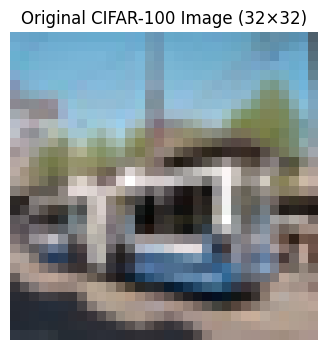

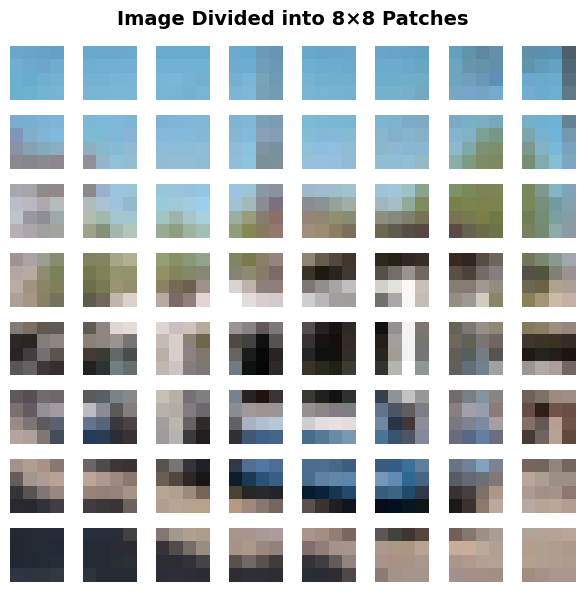

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.title("Original CIFAR-100 Image (32×32)")

# Show patches using the old Patches layer for visualization
patches = Patches(patch_size)(ops.convert_to_tensor([image]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")
plt.suptitle(f"Image Divided into {n}×{n} Patches", fontsize=14, fontweight='bold')
plt.tight_layout()

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        # Patches already projected by ConvPatchEmbedding
        encoded = patch + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
        return config


## Build the Compact Locality-Aware ViT with DeiT-Style Training

This implementation includes several improvements for from-scratch training on CIFAR-100:

**Architecture Enhancements:**
- **Convolutional Patch Embedding**: Uses convolution layers instead of linear projection to maintain spatial locality and inductive bias
- **Compact Design**: Smaller model (192-dim, 6 layers, 3 heads) optimized for 32×32 images
- **Native Resolution**: Works directly with CIFAR-100's 32×32 resolution without upscaling
- **Global Average Pooling**: Uses GAP instead of flattening for better generalization

**DeiT-Style Training Recipe (100 epochs):**
- **Strong Augmentations**: Random flips, rotations (15°), zoom, translation, and contrast
- **Label Smoothing**: 0.1 smoothing to prevent overconfidence
- **Cosine Learning Rate Schedule**: With 5-epoch linear warmup
- **AdamW Optimizer**: With proper weight decay (0.05)
- **Smaller Batch Size**: 128 for better generalization

This configuration is specifically designed for training Vision Transformers from scratch on small datasets,
addressing the common issue where ViTs underperform without strong augmentation and proper regularization.

In [ ]:

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches with locality-aware convolution.
    patches = ConvPatchEmbedding(patch_size, projection_dim)(augmented)
    # Encode patches with positional embeddings.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP with GELU activation (DeiT-style).
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Use global average pooling instead of flatten for better generalization
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:
# Mixup data augmentation callback
# class MixupCallback(keras.callbacks.Callback):
#     def __init__(self, alpha=0.2):
#         super().__init__()
#         self.alpha = alpha

#     def on_train_batch_begin(self, batch, logs=None):
#         # Mixup is applied in the loss function via label smoothing
#         # This is a placeholder for batch-level mixup if needed
#         pass


# Cosine decay with warmup learning rate schedule
class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, total_steps):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        step = ops.cast(step, "float32")
        warmup_steps = ops.cast(self.warmup_steps, "float32")
        total_steps = ops.cast(self.total_steps, "float32")

        # Linear warmup
        warmup_lr = self.initial_learning_rate * step / warmup_steps

        # Cosine decay
        decay_steps = total_steps - warmup_steps
        decay_progress = (step - warmup_steps) / decay_steps
        cosine_decay = 0.5 * (1.0 + ops.cos(np.pi * decay_progress))
        decay_lr = self.initial_learning_rate * cosine_decay

        # Choose warmup or decay
        lr = ops.where(step < warmup_steps, warmup_lr, decay_lr)
        return ops.maximum(lr, 1e-6)  # Minimum learning rate

# Function to implement Mixup
def mixup(images, labels, alpha=0.8):
    """Applies Mixup augmentation to a batch of images and labels."""
    if alpha > 0.:
        # Sample lambda from Beta distribution
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    # Shuffle the batch
    batch_size = ops.shape(images)[0]
    indices = ops.random.permutation(ops.arange(batch_size))

    # Mix images and labels
    mixed_images = lam * images + (1 - lam) * ops.take(images, indices, axis=0)
    mixed_labels = lam * labels + (1 - lam) * ops.take(labels, indices, axis=0) # Assuming one-hot labels

    return mixed_images, mixed_labels

# Helper function for Cutmix bounding box
def get_random_bbox(img_size, lam):
    """Generates random bounding box coordinates for Cutmix."""
    cut_ratio = ops.sqrt(1.0 - lam)
    cut_w = ops.cast(img_size * cut_ratio, 'int32')
    cut_h = ops.cast(img_size * cut_ratio, 'int32')

    # Randomly determine the center of the bounding box
    cx = ops.random.uniform(shape=[], minval=0, maxval=img_size, dtype='int32')
    cy = ops.random.uniform(shape=[], minval=0, maxval=img_size, dtype='int32')

    # Calculate bounding box coordinates
    bbx1 = ops.clip(cx - cut_w // 2, 0, img_size)
    bby1 = ops.clip(cy - cut_h // 2, 0, img_size)
    bbx2 = ops.clip(cx + cut_w // 2, 0, img_size)
    bby2 = ops.clip(cy + cut_h // 2, 0, img_size)

    return bbx1, bby1, bbx2, bby2


# Function to implement Cutmix (Simplified for images)
def cutmix(images, labels, alpha=1.0):
    """Applies Cutmix augmentation to a batch of images and labels."""
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = ops.shape(images)[0]
    image_size = ops.shape(images)[1]

    # Generate bounding box for the cut/paste region
    bbx1, bby1, bbx2, bby2 = get_random_bbox(image_size, lam)

    # Shuffle the batch for the other image
    indices = ops.random.permutation(ops.arange(batch_size))
    images_shuffled = ops.take(images, indices, axis=0)
    labels_shuffled = ops.take(labels, indices, axis=0) # Assuming one-hot labels

    # Apply Cutmix
    # Create a mask for the cut region
    mask = ops.zeros_like(images)
    # Using numpy slicing for simplicity in generating the mask; could be done with ops
    mask = ops.numpy.array(mask) # Convert to numpy for assignment
    mask[:, bby1:bby2, bbx1:bbx2, :] = 1 # Corrected slicing order (y, x)
    mask = ops.convert_to_tensor(mask) # Convert back to tensor

    mixed_images = images * (1 - mask) + images_shuffled * mask

    # Adjust lambda based on the actual area of the cut region
    # Re-calculate lambda based on the actual bounding box size
    lam = 1.0 - ops.cast((bbx2 - bbx1) * (bby2 - bby1), 'float32') / ops.cast((image_size * image_size), 'float32')
    mixed_labels = lam * labels + (1 - lam) * labels_shuffled

    return mixed_images, mixed_labels



def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches with locality-aware convolution.
    patches = ConvPatchEmbedding(patch_size, projection_dim)(augmented)
    # Encode patches with positional embeddings.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.2 # Increased dropout
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP with GELU activation (DeiT-style).
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2) # Increased dropout
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Use global average pooling instead of flatten for better generalization
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.4)(representation) # Increased dropout
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4) # Increased dropout
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


def run_experiment(model):
    # Calculate steps for learning rate schedule
    steps_per_epoch = len(x_train) // batch_size
    total_steps = steps_per_epoch * num_epochs
    warmup_steps = steps_per_epoch * warmup_epochs

    # Learning rate schedule with warmup and cosine decay
    lr_schedule = WarmupCosineDecay(learning_rate, warmup_steps, total_steps)

    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=weight_decay
    )

    # One-hot encode labels for CategoricalCrossentropy with label smoothing
    y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=num_classes)

    # Create a dataset from the training data
    train_dataset = keras.utils.Dataset.from_tensor_slices((x_train, y_train_one_hot))
    train_dataset = train_dataset.shuffle(buffer_size=batch_size * 10).batch(batch_size)

    # Map the mixup/cutmix function to the dataset during training
    # We'll randomly choose between mixup and cutmix for each batch
    # Note: This simplified approach applies it after other augmentations
    # More advanced implementations might integrate it earlier or in a custom loop
    def apply_mixup_cutmix(images, labels):
        # Randomly choose Mixup or Cutmix for the batch
        choice = ops.random.uniform(shape=[], minval=0, maxval=1.0)
        if choice < 0.5: # Apply Mixup
             images, labels = mixup(images, labels, alpha=mixup_alpha)
        else: # Apply Cutmix
             images, labels = cutmix(images, labels, alpha=cutmix_alpha)
        return images, labels

    train_dataset = train_dataset.map(apply_mixup_cutmix, num_parallel_calls=keras.backend.AUTOTUNE)


    model.compile(
        optimizer=optimizer,
        # Use CategoricalCrossentropy for label smoothing
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True,
            label_smoothing=label_smoothing  # DeiT-style label smoothing
        ),
        metrics=[
            # Use CategoricalAccuracy and TopKCategoricalAccuracy with one-hot encoded labels
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint_cifar100_deit_mixup.weights.h5" # Changed checkpoint name
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Early stopping removed to allow full 100 epoch training
    # early_stopping = keras.callbacks.EarlyStopping(
    #     monitor="val_accuracy",
    #     patience=15,
    #     restore_best_weights=True
    # )

    history = model.fit(
        train_dataset, # Use the augmented dataset
        epochs=num_epochs,
        validation_data=(x_test, y_test_one_hot), # Use original test data for validation
        callbacks=[checkpoint_callback],  # Removed early_stopping callback
        verbose=1
    )

    model.load_weights(checkpoint_filepath)
    # Use one-hot encoded labels for evaluation
    _, test_accuracy, test_top_5_accuracy = model.evaluate(x_test, y_test_one_hot, batch_size=batch_size)
    print(f"\n{'='*50}")
    print(f"Test accuracy (after Mixup/Cutmix): {round(test_accuracy * 100, 2)}%")
    print(f"Test top-5 accuracy (after Mixup/Cutmix): {round(test_top_5_accuracy * 100, 2)}%")
    print(f"{'='*50}")

    return history, test_accuracy, test_top_5_accuracy


print("Building compact locality-aware Vision Transformer with Mixup/Cutmix and increased dropout...")
vit_classifier = create_vit_classifier()
vit_classifier.summary()

print("\nTraining with DeiT-style recipe, Mixup/Cutmix, and increased dropout (100 epochs)...")
history, test_acc, test_top5_acc = run_experiment(vit_classifier)


def plot_history(item):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[item], label=f'Training {item}', linewidth=2)
    plt.plot(history.history["val_" + item], label=f'Validation {item}', linewidth=2)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(item.replace('_', ' ').title(), fontsize=12)
    plt.title(f"Training Progress: {item.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_train_val_test_comparison():
    """Plot training, validation, and test accuracy comparison"""
    plt.figure(figsize=(12, 5))

    # Subplot 1: Training and Validation Accuracy over epochs
    plt.subplot(1, 2, 1)
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=2)
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=2)
    plt.axhline(y=test_acc, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_acc*100:.2f}%)')
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training vs Validation vs Test Accuracy", fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Subplot 2: Final comparison bar chart
    plt.subplot(1, 2, 2)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    categories = ['Training\n(Final)', 'Validation\n(Final)', 'Test']
    accuracies = [final_train_acc * 100, final_val_acc * 100, test_acc * 100]
    colors = ['#2ecc71', '#3498db', '#e74c3c']

    bars = plt.bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Final Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot individual metrics
plot_history("loss")
plot_history("accuracy")
plot_history("top-5-accuracy")

# Plot comprehensive train/val/test comparison
print("\n" + "="*50)
print("COMPREHENSIVE ACCURACY COMPARISON AFTER REGULARIZATION")
print("="*50)
plot_train_val_test_comparison()

Building compact locality-aware Vision Transformer...


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          7 │ input_layer_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_patch_embeddi… │ (None, None, 192) │    297,792 │ data_augmentatio… │
│ (ConvPatchEmbeddin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_7     │ (None, 64, 192)   │     12,288 │ conv_patch_embed… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ patch_encoder_7[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 64, 192)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_84[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 64, 768)   │    148,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_141         │ (None, 64, 768)   │          0 │ dense_98[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 64, 192)   │    147,648 │ dropout_141[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_142         │ (None, 64, 192)   │          0 │ dense_99[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_85 (Add)        │ (None, 64, 192)   │          0 │ dropout_142[0][0… │
│                     │                   │            │ add_84[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_85[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_86 (Add)        │ (None, 64, 192)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_85[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_86[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,092,267 (11.80 MB)

 Trainable params: 3,092,260 (11.80 MB)

 Non-trainable params: 7 (32.00 B)


Training with DeiT-style recipe (100 epochs)...
Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 86s 176ms/step - accuracy: 0.0239 - loss: 4.5729 - top-5-accuracy: 0.0980 - val_accuracy: 0.0432 - val_loss: 4.6456 - val_top-5-accuracy: 0.1516
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.0677 - loss: 4.2151 - top-5-accuracy: 0.2365 - val_accuracy: 0.0480 - val_loss: 4.6230 - val_top-5-accuracy: 0.1750
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.1004 - loss: 4.0313 - top-5-accuracy: 0.3072 - val_accuracy: 0.0520 - val_loss: 4.7317 - val_top-5-accuracy: 0.1788
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.1189 - loss: 3.9207 - top-5-accuracy: 0.3481 - val_accuracy: 0.0578 - val_loss: 4.6238 - val_top-5-accuracy: 0.1870
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.1375 - loss: 3.8404 - top-5-accuracy: 0.3748 - val_accuracy: 0.0646 - val_loss: 4.6687 - val_top-5-accuracy: 0.1950
Epoch 6/100
352/352 ━

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Building Vision Transformer...


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_14    │ (None, 32, 32, 3) │          7 │ input_layer_26[0… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_patch_embeddi… │ (None, None, 192) │    297,792 │ normalization_14… │
│ (ConvPatchEmbeddin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_13    │ (None, 64, 192)   │     12,288 │ conv_patch_embed… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ patch_encoder_13… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_156 (Add)       │ (None, 64, 192)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_156[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 64, 768)   │    148,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_261         │ (None, 64, 768)   │          0 │ dense_182[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 64, 192)   │    147,648 │ dropout_261[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_262         │ (None, 64, 192)   │          0 │ dense_183[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_157 (Add)       │ (None, 64, 192)   │          0 │ dropout_262[0][0… │
│                     │                   │            │ add_156[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_157[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_158 (Add)       │ (None, 64, 192)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_157[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_158[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,092,267 (11.80 MB)

 Trainable params: 3,092,260 (11.80 MB)

 Non-trainable params: 7 (32.00 B)


Training with proper augmentation pipeline...
Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 117s 179ms/step - accuracy: 0.0339 - loss: 4.5195 - top-5-accuracy: 0.1266 - val_accuracy: 0.1056 - val_loss: 3.9984 - val_top-5-accuracy: 0.3179
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.1006 - loss: 4.1185 - top-5-accuracy: 0.3050 - val_accuracy: 0.1551 - val_loss: 3.7499 - val_top-5-accuracy: 0.4136
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.1430 - loss: 3.9105 - top-5-accuracy: 0.3968 - val_accuracy: 0.1960 - val_loss: 3.5488 - val_top-5-accuracy: 0.4844
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.1789 - loss: 3.7579 - top-5-accuracy: 0.4528 - val_accuracy: 0.2217 - val_loss: 3.4233 - val_top-5-accuracy: 0.5254
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.2020 - loss: 3.6917 - top-5-accuracy: 0.4852 - val_accuracy: 0.2439 - val_loss: 3.3444 - val_top-5-accuracy: 0.5433
Epoch 6/100
391/391 ━━

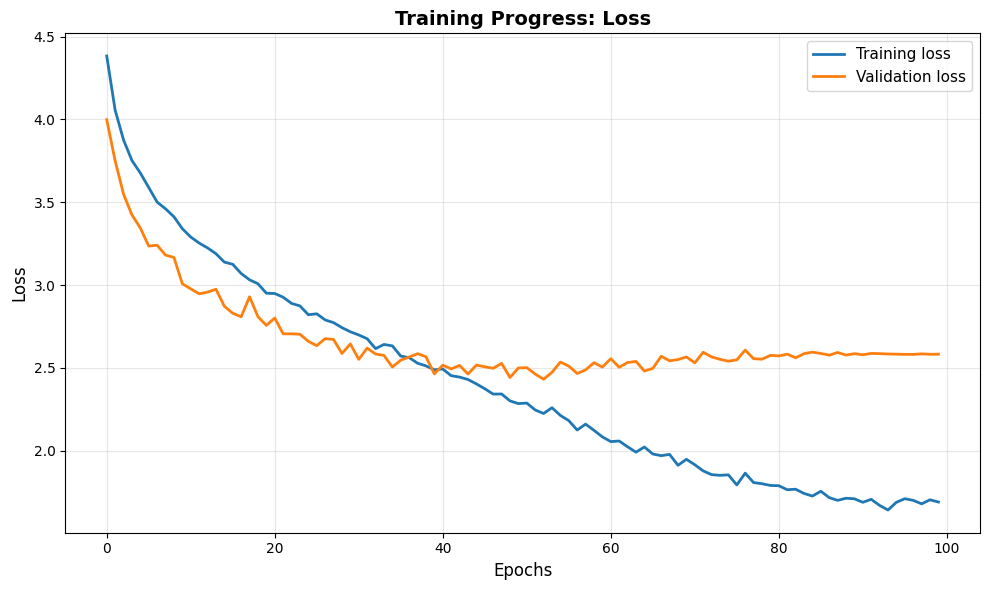

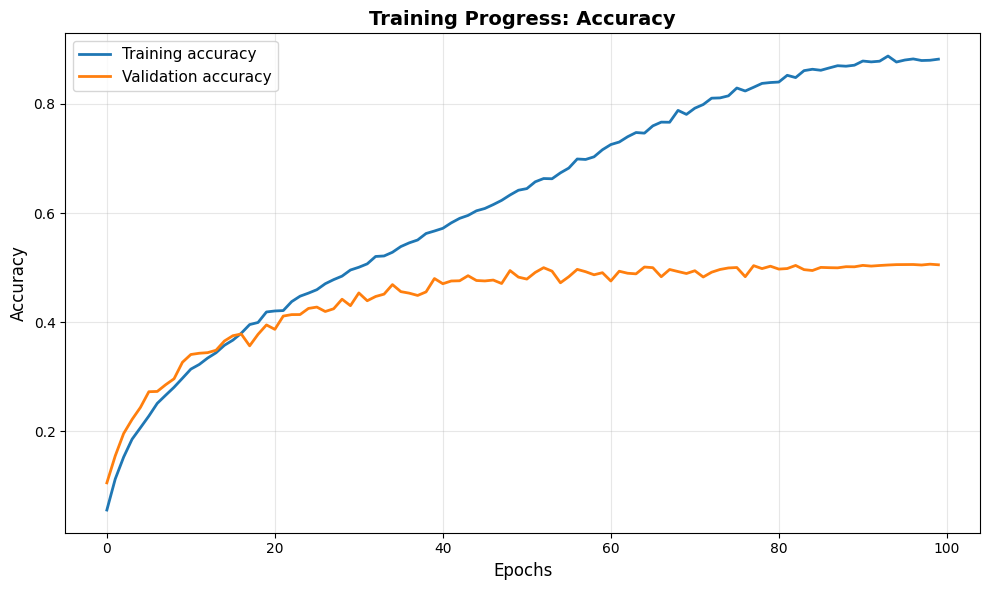

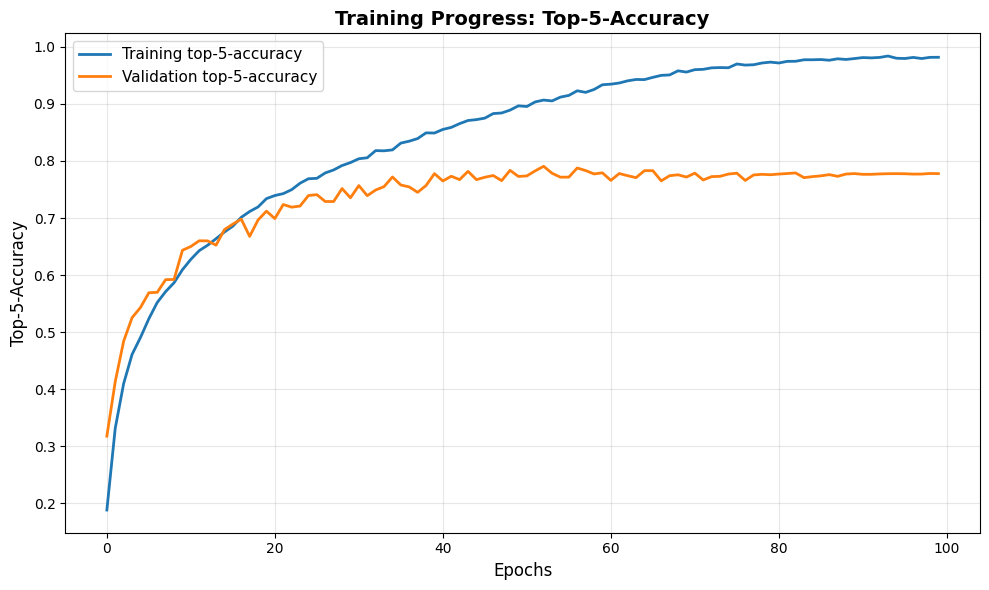

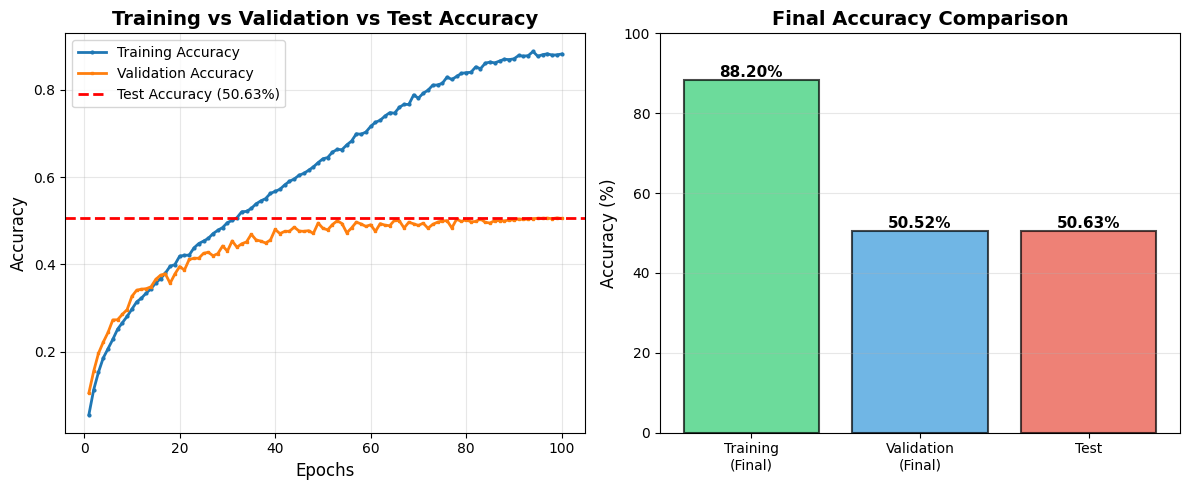

In [98]:
# FIXED: Proper training pipeline to prevent overfitting and data leakage

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers
from keras import ops
import numpy as np
import matplotlib.pyplot as plt

# Load data
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Hyperparameters
learning_rate = 0.001
weight_decay = 0.05
batch_size = 128
num_epochs = 100
warmup_epochs = 5
image_size = 32
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 192
num_heads = 3
transformer_units = [projection_dim * 4, projection_dim]
transformer_layers = 6
mlp_head_units = [projection_dim * 2]

mixup_alpha = 0.2  # Reduced for less aggressive augmentation
cutmix_alpha = 0.2  # Reduced
label_smoothing = 0.1

# CRITICAL FIX: Separate normalization layer for training and inference
normalization_layer = layers.Normalization()
normalization_layer.adapt(x_train)

# Training-only augmentation (NO normalization here)
training_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),  # Reduced from 0.15
        layers.RandomZoom(height_factor=0.1, width_factor=0.1),  # Reduced from 0.2
        layers.RandomTranslation(height_factor=0.05, width_factor=0.05),  # Reduced
        layers.RandomContrast(factor=0.1),  # Reduced from 0.2
    ],
    name="training_augmentation",
)


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class ConvPatchEmbedding(layers.Layer):
    """Convolutional patch embedding for locality awareness"""
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.conv1 = layers.Conv2D(
            projection_dim // 2,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='gelu'
        )
        self.conv2 = layers.Conv2D(
            projection_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='valid'
        )

    def call(self, images):
        images = ops.cast(images, 'float32')
        x = self.conv1(images)
        x = self.conv2(x)
        batch_size = ops.shape(x)[0]
        x = ops.reshape(x, (batch_size, -1, self.projection_dim))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "projection_dim": self.projection_dim
        })
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        encoded = patch + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config


# FIXED: Model WITHOUT built-in augmentation
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    # Apply normalization only (augmentation handled separately)
    normalized = normalization_layer(inputs)

    # Create patches
    patches = ConvPatchEmbedding(patch_size, projection_dim)(normalized)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks with REDUCED dropout
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads,
            dropout=0.1  # Reduced from 0.2
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)  # Reduced
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.2)(representation)  # Reduced from 0.4
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model


class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, total_steps):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        step = ops.cast(step, "float32")
        warmup_steps = ops.cast(self.warmup_steps, "float32")
        total_steps = ops.cast(self.total_steps, "float32")

        warmup_lr = self.initial_learning_rate * step / warmup_steps
        decay_steps = total_steps - warmup_steps
        decay_progress = (step - warmup_steps) / decay_steps
        cosine_decay = 0.5 * (1.0 + ops.cos(np.pi * decay_progress))
        decay_lr = self.initial_learning_rate * cosine_decay

        lr = ops.where(step < warmup_steps, warmup_lr, decay_lr)
        return ops.maximum(lr, 1e-6)


def mixup(images, labels, alpha=0.2):
    """Applies Mixup augmentation"""
    # Ensure correct dtypes
    images = tf.cast(images, tf.float32)
    labels = tf.cast(labels, tf.float32)

    batch_size = tf.shape(images)[0]

    if alpha > 0:
        lam = tf.cast(tf.random.uniform([], 0.8, 1.0), tf.float32)  # Ensure float32
    else:
        lam = tf.constant(1.0, dtype=tf.float32)

    indices = tf.random.shuffle(tf.range(batch_size))
    mixed_images = lam * images + (1 - lam) * tf.gather(images, indices)
    mixed_labels = lam * labels + (1 - lam) * tf.gather(labels, indices)

    return mixed_images, mixed_labels


def cutmix(images, labels, alpha=0.2):
    """Applies Cutmix augmentation"""
    # Ensure correct dtypes
    images = tf.cast(images, tf.float32)
    labels = tf.cast(labels, tf.float32)

    batch_size = tf.shape(images)[0]
    image_size = tf.shape(images)[1]

    if alpha > 0:
        lam = tf.cast(tf.random.uniform([], 0.8, 1.0), tf.float32)  # Ensure float32
    else:
        lam = tf.constant(1.0, dtype=tf.float32)

    # Get bounding box
    cut_ratio = tf.sqrt(1.0 - lam)
    cut_w = tf.cast(tf.cast(image_size, tf.float32) * cut_ratio, tf.int32)
    cut_h = tf.cast(tf.cast(image_size, tf.float32) * cut_ratio, tf.int32)

    cx = tf.random.uniform([], 0, image_size, dtype=tf.int32)
    cy = tf.random.uniform([], 0, image_size, dtype=tf.int32)

    bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, image_size)
    bby1 = tf.clip_by_value(cy - cut_h // 2, 0, image_size)
    bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, image_size)
    bby2 = tf.clip_by_value(cy + cut_h // 2, 0, image_size)

    indices = tf.random.shuffle(tf.range(batch_size))
    images_shuffled = tf.gather(images, indices)
    labels_shuffled = tf.gather(labels, indices)

    # Create mask
    height = image_size
    width = image_size
    channels = tf.shape(images)[3]

    y_coords = tf.range(height)
    x_coords = tf.range(width)
    y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')

    mask = tf.logical_and(
        tf.logical_and(y_grid >= bby1, y_grid < bby2),
        tf.logical_and(x_grid >= bbx1, x_grid < bbx2)
    )
    mask = tf.cast(mask, tf.float32)
    mask = tf.reshape(mask, [1, height, width, 1])
    mask = tf.tile(mask, [batch_size, 1, 1, channels])

    mixed_images = images * (1 - mask) + images_shuffled * mask

    # Adjust lambda - ensure float32
    area_ratio = tf.cast((bbx2 - bbx1) * (bby2 - bby1), tf.float32) / tf.cast(
        image_size * image_size, tf.float32
    )
    lam = tf.cast(1.0 - area_ratio, tf.float32)
    mixed_labels = lam * labels + (1 - lam) * labels_shuffled

    return mixed_images, mixed_labels


def prepare_dataset(x, y, batch_size, training=False):
    """Prepare dataset with proper augmentation"""
    y_encoded = keras.utils.to_categorical(y, num_classes=num_classes).astype('float32')  # Force float32
    dataset = tf.data.Dataset.from_tensor_slices((x, y_encoded))

    if training:
        dataset = dataset.shuffle(10000)

    dataset = dataset.batch(batch_size)

    if training:
        # Apply basic augmentation
        def augment(images, labels):
            images = training_augmentation(images, training=True)
            # Apply mixup or cutmix randomly
            if tf.random.uniform([]) < 0.5:
                images, labels = mixup(images, labels, alpha=mixup_alpha)
            else:
                images, labels = cutmix(images, labels, alpha=cutmix_alpha)
            return images, labels

        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def run_experiment(model):
    steps_per_epoch = len(x_train) // batch_size
    total_steps = steps_per_epoch * num_epochs
    warmup_steps = steps_per_epoch * warmup_epochs

    lr_schedule = WarmupCosineDecay(learning_rate, warmup_steps, total_steps)
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=weight_decay
    )

    # Prepare datasets
    train_dataset = prepare_dataset(x_train, y_train, batch_size, training=True)
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=num_classes).astype('float32')  # Force float32

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True,
            label_smoothing=label_smoothing
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint_cifar100_fixed.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Add early stopping back to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=(x_test, y_test_encoded),
        callbacks=[checkpoint_callback, early_stopping],
        verbose=1
    )

    model.load_weights(checkpoint_filepath)
    _, test_accuracy, test_top_5_accuracy = model.evaluate(
        x_test, y_test_encoded, batch_size=batch_size
    )

    print(f"\n{'='*50}")
    print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
    print(f"Test top-5 accuracy: {round(test_top_5_accuracy * 100, 2)}%")
    print(f"{'='*50}")

    return history, test_accuracy, test_top_5_accuracy


# Train the model
print("Building Vision Transformer...")
vit_classifier = create_vit_classifier()
vit_classifier.summary()

print("\nTraining with proper augmentation pipeline...")
history, test_acc, test_top5_acc = run_experiment(vit_classifier)


# Plotting functions
def plot_history(item):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[item], label=f'Training {item}', linewidth=2)
    plt.plot(history.history["val_" + item], label=f'Validation {item}', linewidth=2)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(item.replace('_', ' ').title(), fontsize=12)
    plt.title(f"Training Progress: {item.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_train_val_test_comparison():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=2)
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=2)
    plt.axhline(y=test_acc, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_acc*100:.2f}%)')
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training vs Validation vs Test Accuracy", fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    categories = ['Training\n(Final)', 'Validation\n(Final)', 'Test']
    accuracies = [final_train_acc * 100, final_val_acc * 100, test_acc * 100]
    colors = ['#2ecc71', '#3498db', '#e74c3c']

    bars = plt.bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Final Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_history("loss")
plot_history("accuracy")
plot_history("top-5-accuracy")
plot_train_val_test_comparison()